# House heating

In a hybrid system we have continuous processes and discrete events interacting in one system. A thermostat is a basic example of this: 

- Heating changes between two states: On and Off. 
- A room cools $\dot{Q_c}\; [J/h]$ at a certain rate proportional to the difference between room temperature $T_r$ and environment temperature $T_e\; [K]$. 
- It heats $\dot{Q_h}\; [J/h]$ at a rate proportional to the temperature difference between temperature of the heating fluid $T_h\; [K]$ and room temperature $T_r\; [K]$.
- The room temperature $T_r$ changes proportional to the difference between heating $\dot{Q_h}$ and cooling $\dot{Q_c}$.

$$\begin{eqnarray}
\dot{Q_c} & = & \frac{\left(T_r - T_e\right)}{\eta R} \; & \left[\tfrac{J}{h}\right], & \mathrm{where\; R = thermal\ resistance\; \left[\tfrac{K h}{J}\right],\; \eta = efficiency\  factor \le 1.0}\\
\dot{Q_h} & = & \alpha \left(T_h - T_r\right) \; & \left[\tfrac{J}{h}\right], & \mathrm{where\; \alpha = proportionality\ factor}\; \left[\tfrac{J}{K h}\right] \\
\dot{T_h} & = & \beta \left(\dot{Q_h} - \dot{Q_c}\right)\; & \left[\tfrac{K}{h}\right], & \mathrm{where\; \beta = proportionality\ factor}\; \left[\tfrac{K}{J}\right]\\
\dot{T_c} & = & - \beta\ \dot{Q_c}\; & \left[\tfrac{K}{h}\right], & \mathrm{when\ heating\ is\ switched\ off.} 
\end{eqnarray}$$

We assume that 
- the thermostat is set to switch heating on if $T_r$ falls under 20°C and to switch heating off if $T_r$ rises above 23°C,
- that time units are hours, 
- the temperature $T_h$ of the heating fluid is 40°C,
- the temperature $T_e$ of the environment follows a stochastic process based on a sine function between 8 and 20°C with $T_{e,min}$ at 4am and $T_{e,max}$ at 4pm,
- the constants have values $R = 1\times10^{-6}\ \left[\frac{K h}{J}\right],\; \alpha = 2\times 10^6\ \left[\frac{J}{K h}\right],\; \beta = 3\times 10^{-7}\; \left[\frac{K}{J}\right]$,
- people entering the room may reduce insulation efficiency by a factor $\eta\le1.0$ to $R$,
- the room temperature is initially $T_{r,0} = 20 °C$ and
- the heater is off.

First we setup the physical model:

In [1]:
using Simulate, Plots, DataFrames, Random, Distributions, LaTeXStrings

@assert Simulate.version ≥ v"0.3.0" "Simulate version $(Simulate.version) should be ≥ 0.3.0"

const Th = 40     # temperature of heating fluid
const R = 1e-6    # thermal resistance of room insulation
const α = 2e6     # represents thermal conductivity and capacity of the air
const β = 3e-7    # represents mass of the air and heat capacity
η = 1.0           # efficiency factor reducing R if doors or windows are open
heating = false

Δte(t, t1, t2) = cos((t-10)*π/12) * (t2-t1)/2  # change rate of a sinusoidal Te

function Δtr(Tr, Te, heating)
    Δqc = (Tr - Te)/(R * η)
    Δqh = heating ? α * (Th - Tr) : 0
    return β * (Δqh - Δqc)
end

Δtr (generic function with 1 method)

We now setup a simulation for 24 hours from 0am to 12am. We update the simulation every virtual minute.

In [3]:
reset!(𝐶)
rng = MersenneTwister(122)
Δt = 1//60
Te = 11
Tr = 20
df = DataFrame(t=Float64[], tr=Float64[], te=Float64[], heating=Int64[])

function setTemperatures(t1=8, t2=20)
    global Te += Δte(tau(), t1, t2) * 2π/1440 + rand(rng, Normal(0, 0.1))
    global Tr += Δtr(Tr, Te, heating) * Δt
    push!(df, (tau(), Tr, Te, Int(heating)) )
end

function switch(t1=20, t2=23)
    if Tr ≥ t2 
        global heating = false
        event!(SF(switch, t1, t2), SF(≤, :Tr, t1))
    elseif Tr ≤ t1 
        global heating = true
        event!(SF(switch, t1, t2), SF(≥, :Tr, t2))
    end
end

Simulate.sample!(SF(setTemperatures), Δt)
switch()

@time run!(𝐶, 24)

  0.033790 seconds (72.61 k allocations: 2.465 MiB)


"run! finished with 0 clock events, 1440 sample steps, simulation time: 24.0"

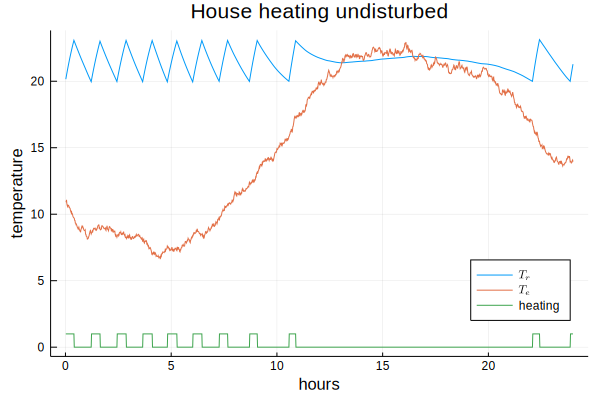

In [4]:
plot(df.t, df.tr, legend=:bottomright, label=L"T_r")
plot!(df.t, df.te, label=L"T_e")
plot!(df.t, df.heating, label="heating")
xlabel!("hours")
ylabel!("temperature")
title!("House heating undisturbed")

In a living room the thermal resistance is repeatedly diminished if people enter the room or open windows.

In [6]:
function people()
    delay!(6 + rand(Normal(0, 0.5)))
    sleeptime = 22 + rand(Normal(0, 0.5))
    while tau() < sleeptime
        global η = rand()                    # open door or window
        delay!(0.1 * rand(Normal(1, 0.3)))   # for some time
        global η = 1.0                       # close it again
        delay!(rand())
    end
end

reset!(𝐶)
rng = MersenneTwister(122)
Random.seed!(1234)
Te = 11
Tr = 20
df = DataFrame(t=Float64[], tr=Float64[], te=Float64[], heating=Int64[])

for i in 1:2                                 # put 2 people in the house
    process!(SP(i, people), 1)               # run process only once
end
Simulate.sample!(SF(setTemperatures), Δt)
switch()

@time run!(𝐶, 24)

  0.107152 seconds (53.20 k allocations: 1.226 MiB)


"run! finished with 116 clock events, 1440 sample steps, simulation time: 24.0"

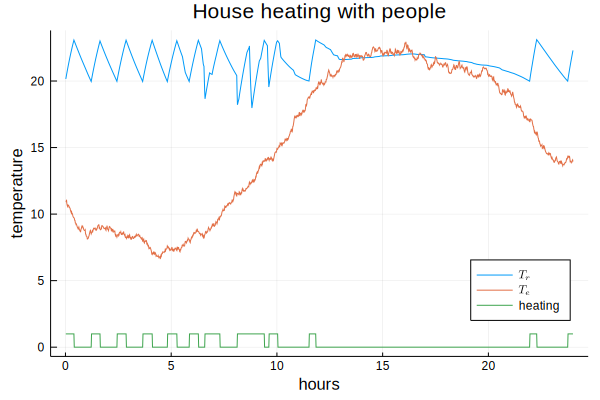

In [7]:
plot(df.t, df.tr, legend=:bottomright, label=L"T_r")
plot!(df.t, df.te, label=L"T_e")
plot!(df.t, df.heating, label="heating")
xlabel!("hours")
ylabel!("temperature")
title!("House heating with people")

We have now all major schemes: events, continuous sampling and processes combined in one example.